# Import packages

In [23]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.despine()
sns.set_context('notebook') 
sns.set_style('ticks') 

colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)

# Import dataset

In [44]:
train = pd.read_csv('train.csv').drop(columns='Id')
test = pd.read_csv('test.csv').drop(columns='Id')

pd.set_option('display.max_columns', 100)
train.head()

,price,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,reviews_per_month
0,150,f,22.0,t,-33.846469,151.205171,Apartment,Entire home/apt,2,1.0,1,1.0,500.0,330.0,0,7,1125,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,strict,0.53
1,66,f,1.0,t,-33.895736,151.173529,Apartment,Private room,2,1.5,1,1.0,NaN,NaN,0,21,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,flexible,NaN
2,325,t,1.0,t,-33.879322,151.222408,House,Entire home/apt,4,2.0,2,2.0,500.0,180.0,0,3,90,21,99.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,moderate,2.38
3,145,f,1.0,f,-33.856874,151.149600,House,Entire home/apt,6,1.5,3,4.0,0.0,80.0,0,4,1125,3,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,flexible,1.96
4,200,f,6.0,t,-33.907150,151.178552,House,Entire home/apt,4,1.0,2,2.0,350.0,85.0,50,2,30,22,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,moderate,2.73


In [45]:
# Variables
response = ['price']

categorical = ['host_is_superhost', 'host_identity_verified', 'property_type', 'room_type',
               'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

continuous = ['host_total_listings_count', 'security_deposit', 'cleaning_fee', 'extra_people',
              'minimum_nights','maximum_nights']

discrete = ['accommodates', 'bathrooms', 'bedrooms', 'beds']

reviews = ['number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
           'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
           'review_scores_location', 'review_scores_value', 'reviews_per_month']

coordinates = ['latitude', 'longitude']

predictors = categorical + continuous + discrete + reviews + coordinates

# Data Processing

In [46]:
# Missing data
missing_data = train.isnull().sum(axis=0).reset_index()
missing_data.columns = ['Predictor', 'Count of NaN values']
missing_data['Missing Ratio'] = missing_data['Count of NaN values'] / train.shape[0]
missing_data.loc[missing_data['Missing Ratio'] > 0]

,Predictor,Count of NaN values,Missing Ratio
1,host_is_superhost,2,0.002
2,host_total_listings_count,2,0.002
3,host_identity_verified,2,0.002
9,bathrooms,3,0.003
11,beds,2,0.002
12,security_deposit,426,0.426
13,cleaning_fee,307,0.307
18,review_scores_rating,340,0.340
19,review_scores_accuracy,342,0.342
20,review_scores_cleanliness,342,0.342


In [57]:
import scipy

# Tests for skewness of data, to determine whether to scale with median or mean
skewed = []
non_skewed = []

for i in continuous+discrete+reviews:
    p = scipy.stats.skewtest(train[i], nan_policy='omit')[1] # calculates skewtest p_value (H0 = normally distributed)
    if p < 0.01:
        skewed.append(i)
    else:
        non_skewed.append(i)
        
print('Skewed variables are:\n{0}\n\nNon-skewed variables are:\n{1}'.format(skewed, non_skewed))

Skewed variables are:
['host_total_listings_count', 'security_deposit', 'cleaning_fee', 'extra_people', 'minimum_nights', 'maximum_nights', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']

Non-skewed variables are:
[]


Above, we see that everything is significantly skewed with a p-value of 0.01 - this is visually confirmed with EDA further below

In [27]:
# to justify imputing with 'f'
col = 'host_is_superhost'
pd.crosstab(train[col], train[col])

host_is_superhost,f,t
host_is_superhost,,
f,905,0
t,0,93


Above, we see one example of why we impute with 'false' vs. true

### Imputing missing data

In [28]:
def impute(data):
    '''
    Imputes missing data in test / train sets for Airbnb data
    '''
    
    # Categoricals
    data['host_is_superhost'].fillna(value='f', inplace=True)
    data['host_identity_verified'].fillna(value='f', inplace=True)

    # No costs
    data['security_deposit'].fillna(value=0, inplace=True)
    data['cleaning_fee'].fillna(value=0, inplace=True)

    # Medians
    for i in discrete+continuous:
        data[i].fillna(value=np.nanmedian(data[i]), inplace=True)

    # Reviews
    zero_reviews = data[reviews].loc[data['number_of_reviews'] == 0]
    zero_reviews.fillna(value=0, inplace=True)

    nonzero_reviews = data[reviews].loc[data['number_of_reviews'] > 0]
    data_reviews = pd.concat([zero_reviews, nonzero_reviews], axis=0).sort_index()

    for i in data_reviews.columns:
        data_reviews[i].fillna(value=np.nanmedian(data_reviews[i]), inplace=True)

    data = data.drop(columns=data[reviews].columns)
    data = pd.concat([data, data_reviews], axis=1)
    
    return data

data = impute(train.copy())

# Exploratory Data Analysis

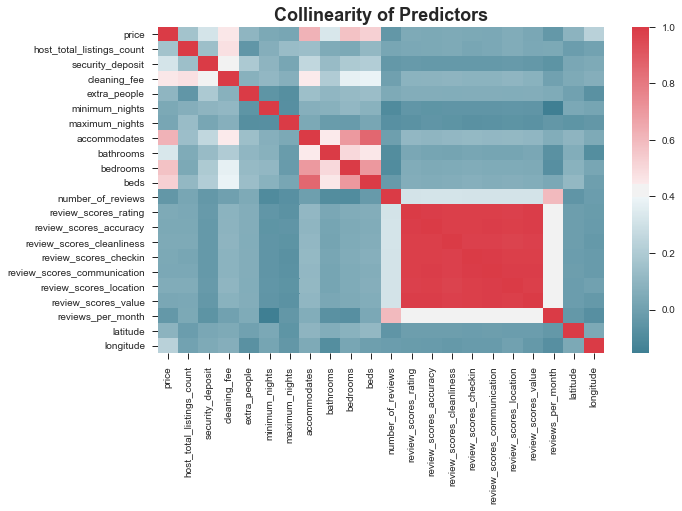

In [11]:
# Correlation matrix for all variables against each other
fig, ax = plt.subplots(figsize=(10,6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data[response+predictors].corr(), ax=ax, cmap=cmap)
ax.set_title('Collinearity of Predictors', fontweight='bold', fontsize=18)

plt.show()

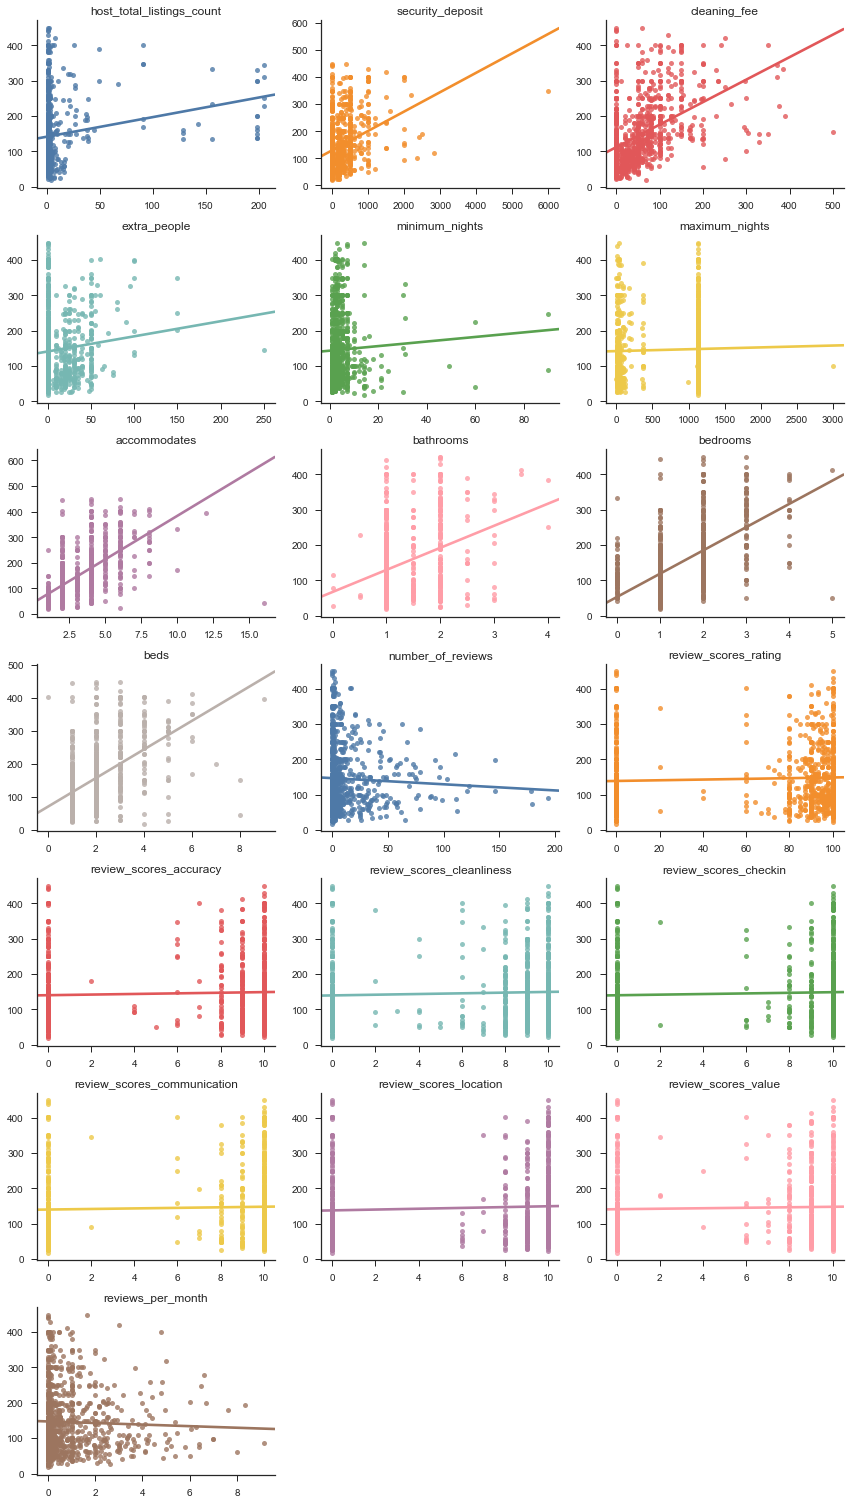

In [9]:
from statlearning import plot_regressions
with sns.color_palette(crayon):
    plot_regressions(data[continuous+discrete+reviews], data['price'])
    plt.show()

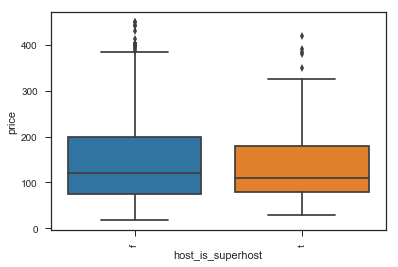

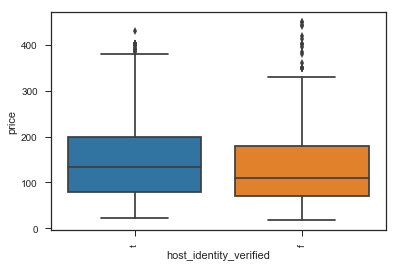

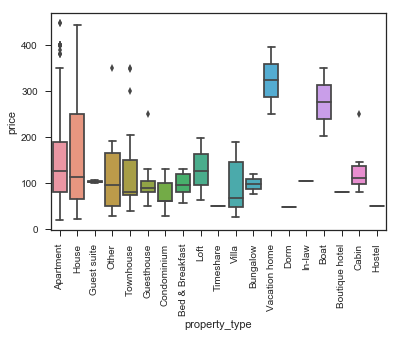

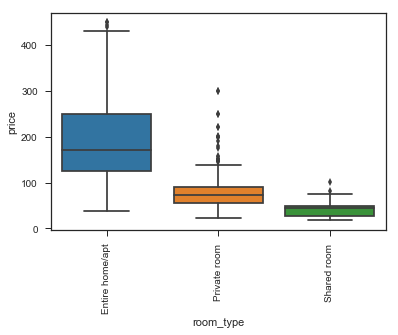

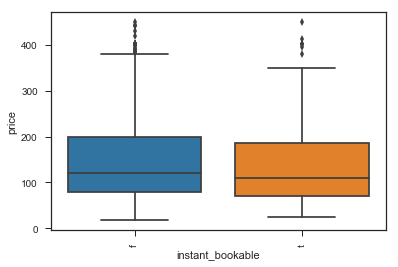

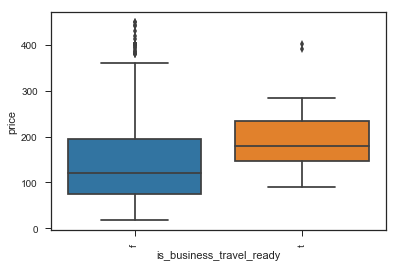

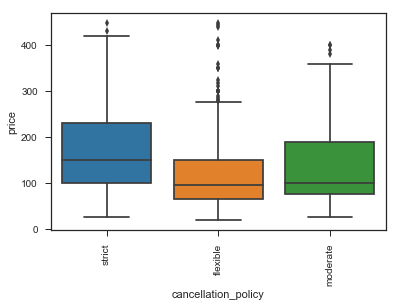

In [13]:
# Boxplots for each categorical variable against price 
fig = plt.figure()
for i in categorical: 
    fig, ax = plt.subplots()
    sns.boxplot(x=i, y = 'price', data=data)
    ax.set_xticklabels(data[i].unique(), rotation = 'vertical')
    plt.show()

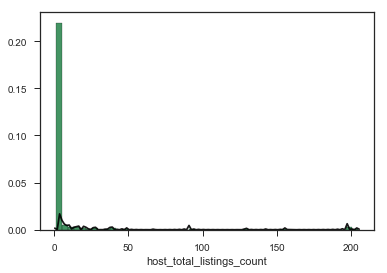

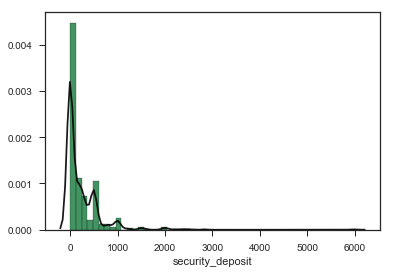

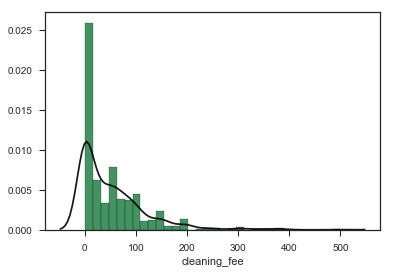

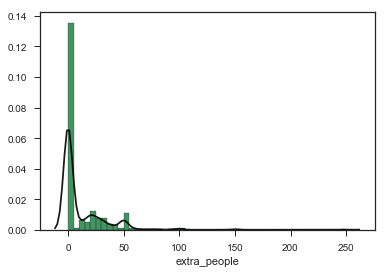

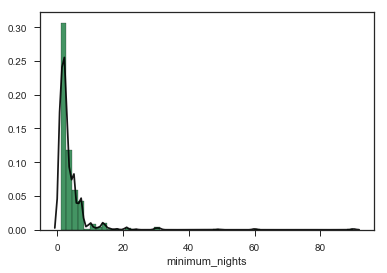

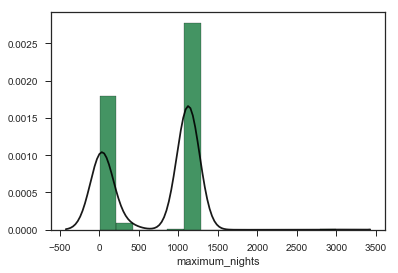

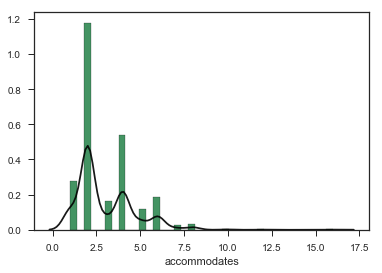

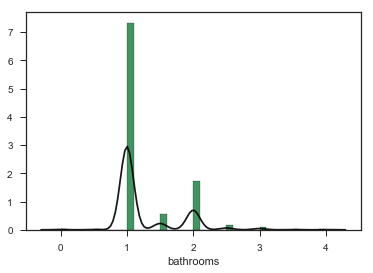

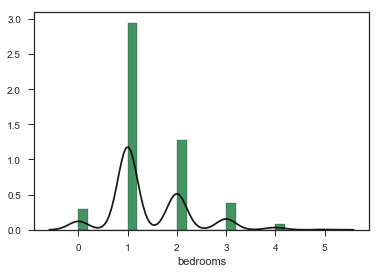

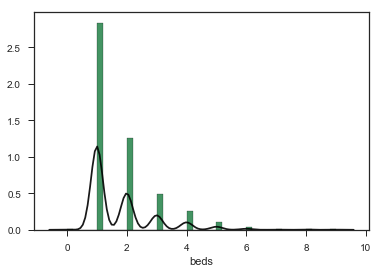

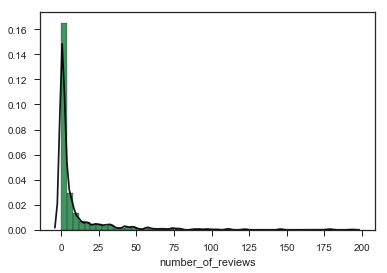

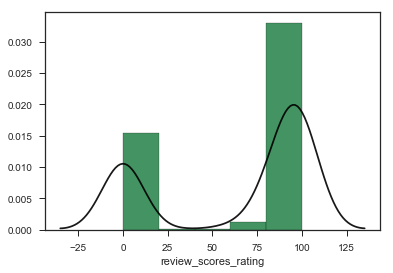

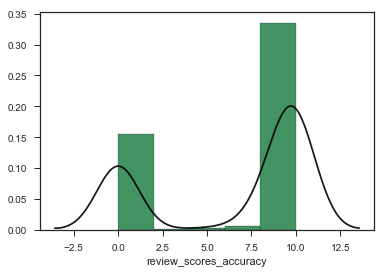

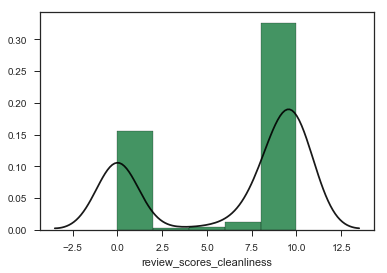

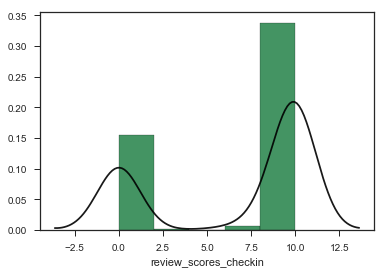

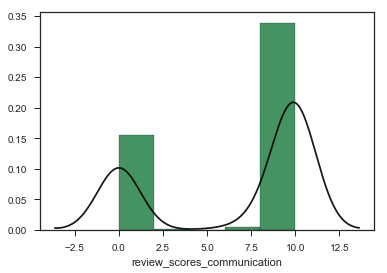

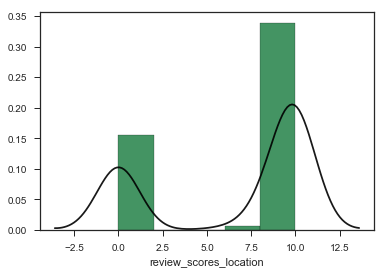

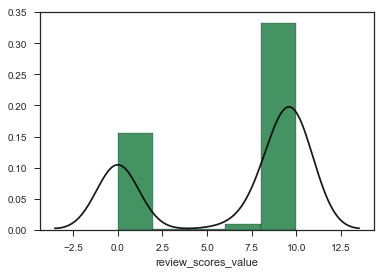

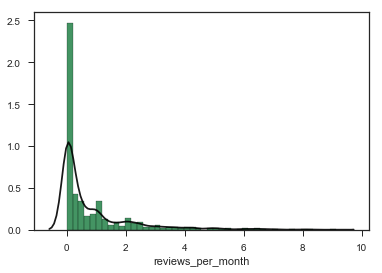

In [17]:
# EDA to help determine logs
def hist(series):
    fig, ax = plt.subplots()
    sns.distplot(series, ax=ax,
                 hist_kws={'alpha': 0.75,
                           'edgecolor':'black',
                           'color': sns.color_palette('Greens')[-1]},  
                 kde_kws={'color': 'black', 'alpha': 0.9})
    return plt.show()

for i in continuous+discrete+reviews:
    hist(data[i])

### Testing log transformation of price

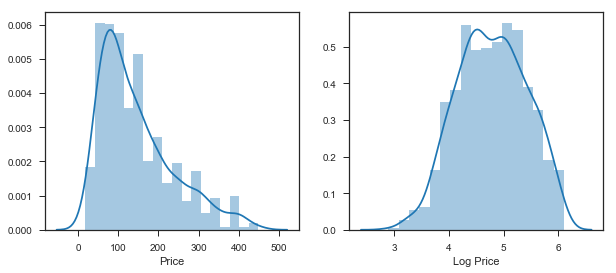

In [10]:
# Distribution of price

fig, ax = plt.subplots(1, 2, figsize=(10,4))

sns.distplot(data['price'], ax=ax[0])
ax[0].set_xlabel('Price')

sns.distplot(np.log(data['price']), ax=ax[1])
ax[1].set_xlabel('Log Price')

plt.show()

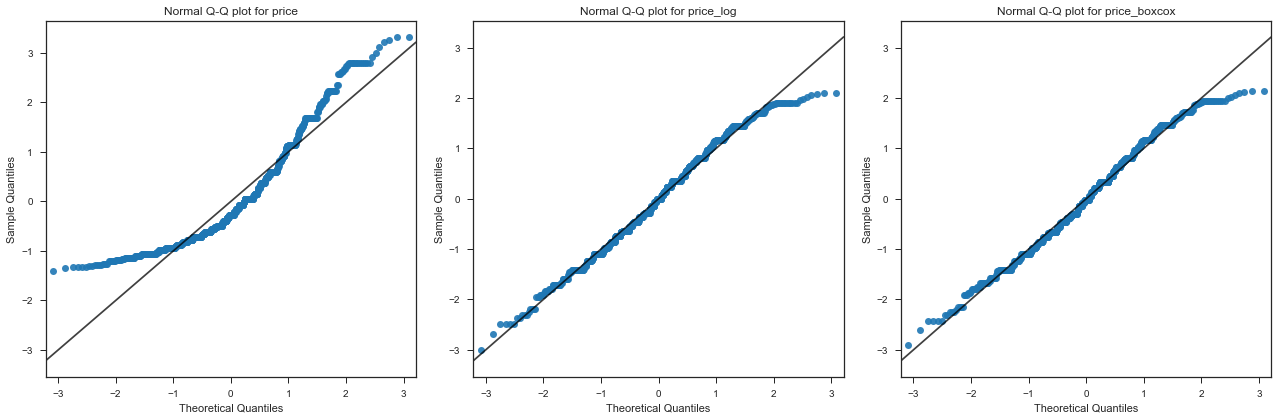

In [36]:
import scipy
from scipy import stats

# Normality of price
data['price_log'] = np.log(data['price'])
data['price_boxcox'] = scipy.stats.boxcox(data['price'])[0]

import statsmodels.api as sm
label = ['price', 'price_log', 'price_boxcox']

fig, ax = plt.subplots(1, 3, figsize = (18,6))
i = 0
for series in label:
    pp = sm.ProbPlot(data[series], fit=True)
    qq = pp.qqplot(color=sns.color_palette()[0], alpha=0.9, ax=ax[i])
    a = ax[i].get_xlim()[0]
    b = ax[i].get_xlim()[1]
    ax[i].plot([a,b], [a,b], color='black', alpha=0.75)
    ax[i].set_xlim(a, b)
    ax[i].set_title('Normal Q-Q plot for {}'.format(series))
    i += 1

plt.tight_layout()
plt.show()

### Kruskal-Wallis ANOVA Test
Helps identify whether classes are conditionally independent

In [13]:
from scipy import stats

# Non-parametric Kruskal-Wallis ANOVA rank test - discrete variables
H = []
p = []

for i in categorical+discrete:
    h, pval = stats.kruskal(*[data.loc[data[i]==v,'price'] for v in data[i].unique()])
    H.append(h)
    p.append(pval)

# Calculates significance at 1% and appends results
test_results = []
for value in p:
    if value < 0.01:
        test_results.append('True')
    else:
        test_results.append('False')

# Creates tables with the values above
table = pd.DataFrame(H, columns=['H Stat'], index=categorical+discrete)
table['p values'] = pd.DataFrame(p, index=categorical+discrete)
table['Reject, \u03b1=0.01'] = pd.DataFrame(test_results, index=categorical+discrete)

table.round(2)

,H Stat,p values,"Reject, α=0.01"
host_is_superhost,0.55,0.46,False
host_identity_verified,13.43,0.00,True
property_type,33.54,0.01,False
room_type,533.00,0.00,True
instant_bookable,2.97,0.08,False
is_business_travel_ready,10.81,0.00,True
cancellation_policy,76.36,0.00,True
accommodates,456.46,0.00,True
bathrooms,70.39,0.00,True
bedrooms,351.51,0.00,True


### Variance inflation factor
Helps determine variables which may need to be removed due to high collinearity

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculating VIF for multicollinearity check
pred = continuous + discrete + reviews + coordinates

X = data[pred].as_matrix()
VIF = pd.DataFrame([np.sqrt(variance_inflation_factor(X,j)) for j in range(len(pred))], index=pred, columns=['SQRT(VIF)'])

VIF.sort_values(by='SQRT(VIF)', ascending=False).round(2)

,SQRT(VIF)
longitude,484.33
latitude,484.31
review_scores_rating,17.13
review_scores_communication,17.13
review_scores_checkin,16.30
review_scores_value,15.24
review_scores_accuracy,15.19
review_scores_location,12.73
review_scores_cleanliness,11.40
accommodates,4.25


### Map of coordinates
Most are around CBD, helps justify using distance metric (instead of clustering or post codes)

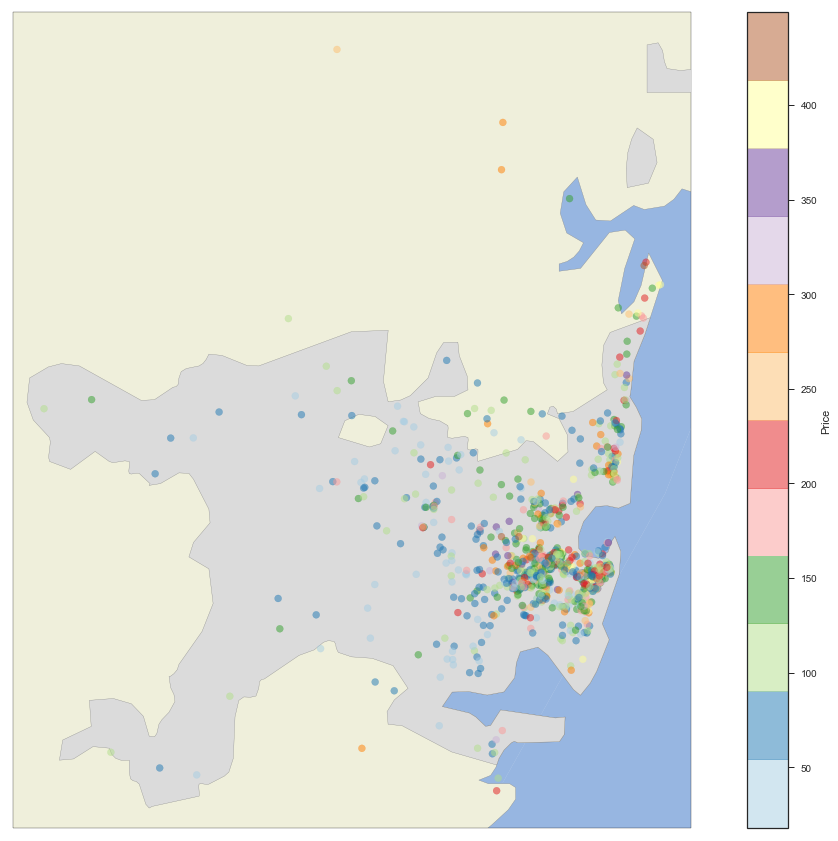

In [15]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize = (20,15)) # Plot

ax = plt.axes(projection=ccrs.Mercator()) # Map projection
ax.coastlines(resolution='10m') 

land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m',
                                    facecolor=cfeature.COLORS['land'])

pop = cfeature.NaturalEarthFeature(category='cultural', name='urban_areas', scale='10m', 
                                   facecolor=cfeature.COLORS['land_alt1'])

ax.add_feature(cfeature.LAND, facecolor=cfeature.COLORS['water'], zorder=1)
ax.add_feature(cfeature.OCEAN, zorder=1)

ax.add_feature(pop, edgecolor='gray', zorder=3)
ax.add_feature(land, edgecolor='gray', zorder=2)

plt.scatter(data['longitude'], data['latitude'], c=data['price'], alpha=0.5, transform=ccrs.Geodetic(), 
            cmap='Paired', zorder=8)

plt.colorbar().set_label('Price')
plt.show()

### Checking for interactions
_Note: this is a non-exhaustive list_

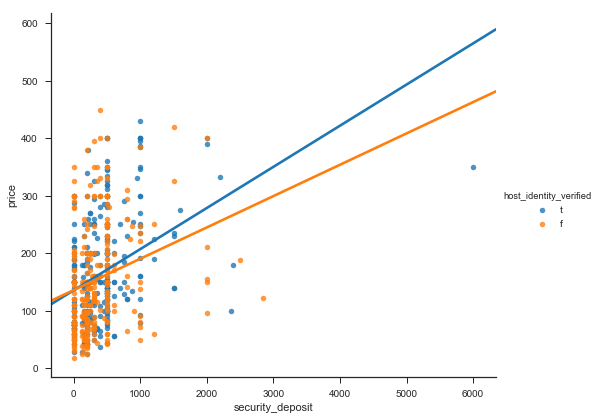

In [30]:
sns.lmplot('security_deposit', 'price', data=train, hue='host_identity_verified', size=6, aspect=1.2, scatter_kws={'s': 30}, ci=None)
plt.show()

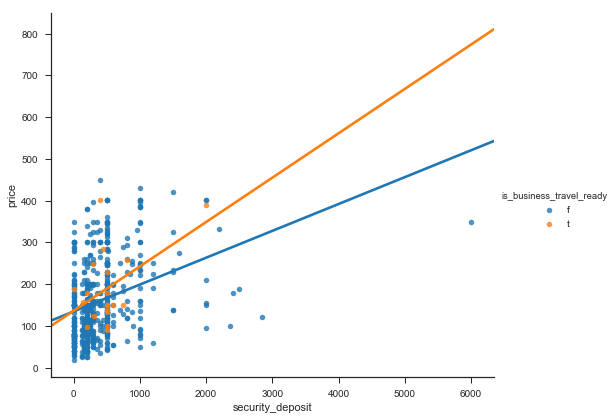

In [31]:
sns.lmplot('security_deposit', 'price', data=train, hue='is_business_travel_ready', size=6, aspect=1.2, scatter_kws={'s': 30}, ci=None)
plt.show()

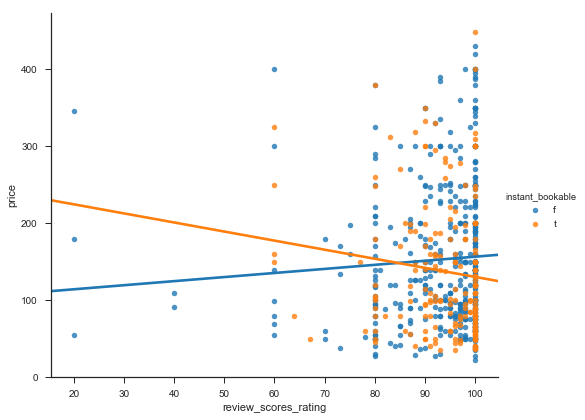

In [32]:
sns.lmplot('review_scores_rating', 'price', data=train, hue='instant_bookable', size=6, aspect=1.2, scatter_kws={'s': 30}, ci=None)
plt.show()